In [86]:
import sqlalchemy
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
Base= automap_base()
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from scipy import stats

In [87]:
database_path='\hawaii.sqlite'
engine=create_engine(f'sqlite:///{database_path}')
conn= engine.connect()
Base.prepare(engine, reflect= True)
Base.classes.keys()
Measurement= Base.classes.measurement
Station= Base.classes.station
session=Session(engine)

In [88]:
# Temperature Analysis I
## Average temperature in June and Dec at all stations across all available years in the dataset
june='06'
dec='12'
average_june=session.query(func.avg(Measurement.tobs)).\
            filter(func.strftime("%m", Measurement.date) == june).all()
average_dec=session.query(func.avg(Measurement.tobs)).\
            filter(func.strftime("%m", Measurement.date) == dec).all()
print(f'Average temperature in June is {list(np.ravel(average_june))} and in December is {list(np.ravel(average_dec))}')

Average temperature in June is [74.94411764705882] and in December is [71.04152933421226]


In [107]:
## Use the paired t-test to determine whether the difference in the means, if any, is statistically significant
temp_june=session.query(Measurement.date,Measurement.tobs).\
            filter(func.strftime("%m", Measurement.date) == june).all()
temp_dec=session.query(Measurement.date, Measurement.tobs).\
            filter(func.strftime("%m", Measurement.date) == dec).all()
df_temp_june=pd.DataFrame(temp_june)
df_temp_june['tobs']
df_temp_dec=pd.DataFrame(temp_dec)
df_temp_dec['tobs']
(t_stat, p) = stats.ttest_ind(df_temp_june['tobs'], df_temp_dec['tobs'], equal_var=False)
print("t-statistics is {}.".format(t_stat))
print("p-value is {}.".format(p))
if p < 0.05:
    print("The difference in sample means is significant.")
else:
    print("The difference in sample means is not significant.")

t-statistics is 31.355036920962423.
p-value is 4.193529835915756e-187.
The difference in sample means is significant.


In [74]:
# Temperature Analysis II
## Calculate min, avg, max temps for the trip from 02/28/2017 to 03/05/2017
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
my_start='2017-02-28'
my_end='2017-03-05'
my_trip_data = list(np.ravel(calc_temps(my_start, my_end)))
my_trip_data

[64.0, 72.02777777777777, 78.0]

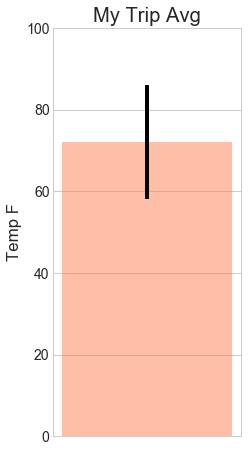

In [75]:
## Plot min, avg, max temps for the trip from 02/28/2017 to 03/05/2017
plt.figure(0)
style.use('seaborn-whitegrid')
ptp=my_trip_data[2]-my_trip_data[0]
y=[my_trip_data[1]]
x_axis = np.arange(len(y))
plt.bar(x_axis, y, color='coral', alpha=0.50,yerr=ptp)
plt.ylim(0,100)
plt.ylabel("Temp F")
plt.title("My Trip Avg")
plt.xticks([], [])
plt.rcParams["figure.figsize"] = [3, 7]
plt.savefig('myTripTemp.png')
plt.show()

In [76]:
# Daily Rainfall Average
station_rain=[Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
station_rainfall= session.query(*station_rain).\
    filter(Station.station==Measurement.station).\
    filter(Measurement.date>=my_start).\
    filter(Measurement.date<=my_end).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
station_rainfall

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  4.720000000000001),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 4.45),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.07),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2.98),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  2.7399999999999998),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.32),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.1600000000000001)]

In [77]:
def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
date_list=["02-28","02-29","03-01","03-02","03-03","03-04","03-05"]
normal_list=[]
for date in date_list:
    x=daily_normals(date)
    x_unzip=list(np.ravel(x))
    normal_list.append(x_unzip)
normal_list


[[65.0, 70.65517241379311, 80.0],
 [67.0, 71.73333333333333, 79.0],
 [64.0, 70.0327868852459, 76.0],
 [61.0, 70.36666666666666, 78.0],
 [60.0, 70.06896551724138, 78.0],
 [57.0, 69.27272727272727, 77.0],
 [60.0, 67.89090909090909, 76.0]]

In [80]:
df_normal=pd.DataFrame(normal_list, columns=['tmin', 'tavg','tmax'])
df_normal['date'] = pd.date_range(start='2/28/2017', periods=len(df_normal), freq='D')
df_normal_final=df_normal.set_index('date')
df_normal_final

,tmin,tavg,tmax
date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,67.0,71.733333,79.0
2017-03-02,64.0,70.032787,76.0
2017-03-03,61.0,70.366667,78.0
2017-03-04,60.0,70.068966,78.0
2017-03-05,57.0,69.272727,77.0
2017-03-06,60.0,67.890909,76.0


<Figure size 504x360 with 0 Axes>

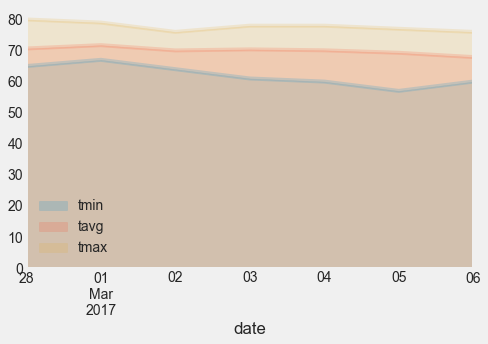

In [85]:
# Plot daily normal for my trip from 02/28/2017 to 03/05/2017
plt.figure(1)
style.use('fivethirtyeight')
df_normal_final.plot.area(stacked=False, alpha=0.18)
plt.xlabel('date')
plt.grid()
plt.tight_layout()
plt.rcParams["figure.figsize"] = [7, 5]
plt.savefig('myTripDailyNormal.png')
plt.show()